# Query MLP vs Transformer Network

### Setup

In [1]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
from acousticnn.mmo import get_dataloader, Iter_Dataset
from acousticnn.mmo import train
from acousticnn.utils.builder import build_opti_sche, build_model
from acousticnn.utils.logger import init_train_logger, print_log
from acousticnn.utils.argparser import get_args, get_config
from torchinfo import summary
import wandb 
import time
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams["text.usetex"] = True

### Plot functions

In [2]:
def plot_loss(losses_per_f, f, ax=None, quantile=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    losses_per_f = losses_per_f.transpose(0, 2, 1).reshape(-1, 200)
    mean = np.mean(losses_per_f, axis=0)
    std = np.std(losses_per_f, axis=0)
    ax.semilogx(f, mean)
    if quantile is not None:
        quantiles = np.quantile(losses_per_f, [0+quantile, 1-quantile], axis=0)
        ax.fill_between(f, quantiles[0], quantiles[1], alpha=0.2)

    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('rmse dB re 1m')
    return ax

def plot_results(prediction, amplitude, f, ax=None, quantile=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 12))

    ax.semilogx(f, amplitude, c='black', alpha = 0.8)
    ax.semilogx(f, prediction, c='red', linestyle = 'dashed')
    
    ax.grid(True)
    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('Amplitude in dB re 1m')
    
    return ax

### Loader and prediction functions

{'n_masses': 4, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9785) tensor(6.9809)
tensor(0.5434) tensor(0.2591)
tensor(15.3790) tensor(8.3880)
tensor(0.1859) tensor(2.4163)
tensor(-0.0086) tensor(2.7924)
tensor(-0.0660) tensor(2.5907)
tensor(-0.0403) tensor(2.7960)


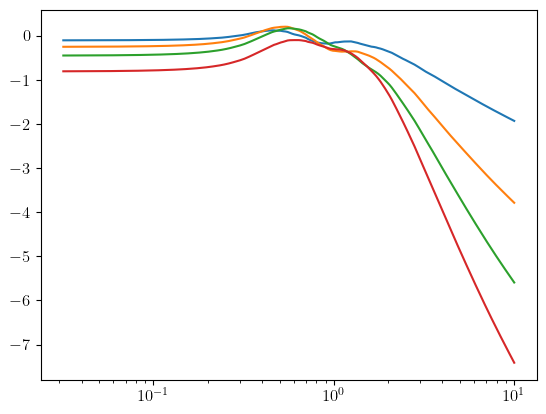

In [3]:
args = get_args(["--config", r"grid_mlp.yaml"])
args.encoding = "none"
config = get_config(args.config)

def get_dataloader_helper(n_masses, n_samples, test, batch_size):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    parameters_dataset = {"n_masses": n_masses, 
            "sample_f": False,
            "f_per_sample": 200,
            "sample_m": True,
            "m_range": (1, 25),
            "sample_d": True,
            "d_range": (0.1, 1),
            "sample_k": True,
            "k_range": (1, 30),
            "normalize": False,
            "normalize_factor": 10,
            "f_range": (-1.5, 1)
    }    
    if args.encoding == "none":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "none"
    elif args.encoding == "random":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "random"
    elif args.encoding == "sin":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 100
        config.model.input_encoding = "sin"
    else:
        raise NotImplementedError
    return get_dataloader(args, config, test=test, n_samples=n_samples, parameters=parameters_dataset, batch_size=batch_size)
valloader = get_dataloader_helper(4, 1000, True, 100)
f = np.logspace(-1.5, 1, 200)

ref = torch.mean(valloader.dataset.amplitude, dim=0).unsqueeze(0)
plt.semilogx(f, ref[0])

def generate_prediction():
    pred, amp, losses, losses_per_f = [], [], [], []
    with torch.no_grad():
        for frequency, parameters, amplitude in valloader: 
            frequency, parameters, amplitude = frequency.to(args.device), [par.to(args.device) for par in parameters], amplitude.to(args.device)
            prediction = net(frequency, parameters) # B x num_masses x num_frequencies  
            prediction = prediction * 10
            amplitude = amplitude * 10  
            loss = torch.nn.functional.mse_loss(prediction, amplitude)
            amplitude, prediction = amplitude.cpu(), prediction.cpu()
            pred.append(prediction), amp.append(amplitude), losses.append(loss.cpu())
            losses_per_f.append(torch.nn.functional.mse_loss(prediction, amplitude, reduction="none").detach().cpu().numpy())

    losses_per_f = np.vstack(losses_per_f)
    rmse_per_f = np.sqrt(losses_per_f)
    # prediction, amplitude = np.vstack(pred)- ref.numpy(), np.vstack(amp)- ref.numpy()
    prediction, amplitude = np.vstack(pred), np.vstack(amp)
    print(np.mean(losses_per_f)) 
    return prediction, amplitude, rmse_per_f

## MLP prdictions

In [4]:
# mlp
config = get_config(r'configs\query_mlp.yaml')
config.model.input_encoding = "none"
args.device = "cpu"
path = r"paper_plots\checkpoints\query_mlp\checkpoint_best"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond1, amplitude_cond1, losses_per_f_cond1 = generate_prediction()

# %%
loss_per_sample_1 = np.mean(np.mean(losses_per_f_cond1, axis=1), axis=1)
print(np.argmin(loss_per_sample_1), np.argmax(loss_per_sample_1))
print(loss_per_sample_1[np.argmin(loss_per_sample_1)], loss_per_sample_1[np.argmax(loss_per_sample_1)])


0.10093473
757 20
0.07259707 0.73962593


## Transformer predictions

In [5]:
# %%
# transformer
config = get_config(r'configs\query_transformer.yaml')
config.model.input_encoding = "none"
path = r"paper_plots\checkpoints\query_transformer\checkpoint_best"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()

# %%
loss_per_sample_2 = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample_2), np.argmax(loss_per_sample_2))
print(loss_per_sample_2[np.argmin(loss_per_sample_2)], loss_per_sample_2[np.argmax(loss_per_sample_2)])


0.004795281
211 730
0.009419805 0.17900318


## Plots

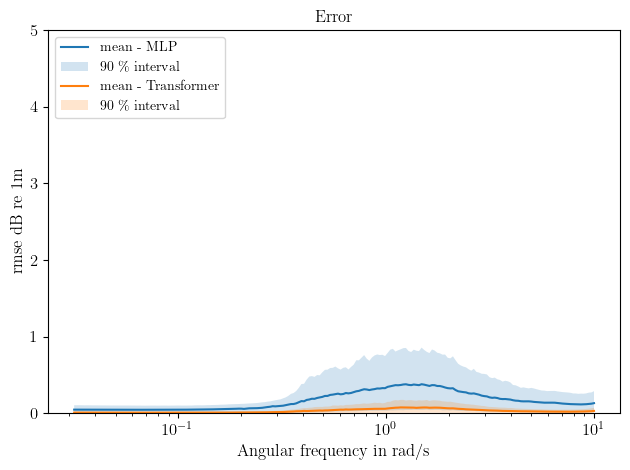

In [6]:
legend_font_size = 10
# Loss plots
fig, ax = plt.subplots(1, 1)
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot.set_title("Error")
plot.legend(["mean - MLP","90 \% interval", "mean - Transformer", " 90 \% interval"], ncol = 1, prop = {'size': legend_font_size}, loc = 'upper left')
plot.set_ylim([0.0, 5.0])
plt.tight_layout()

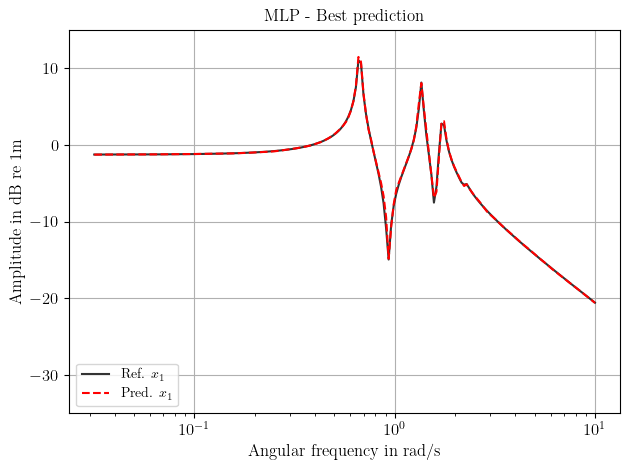

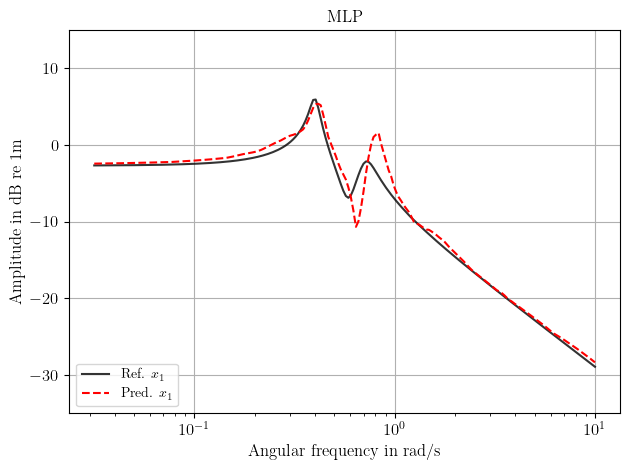

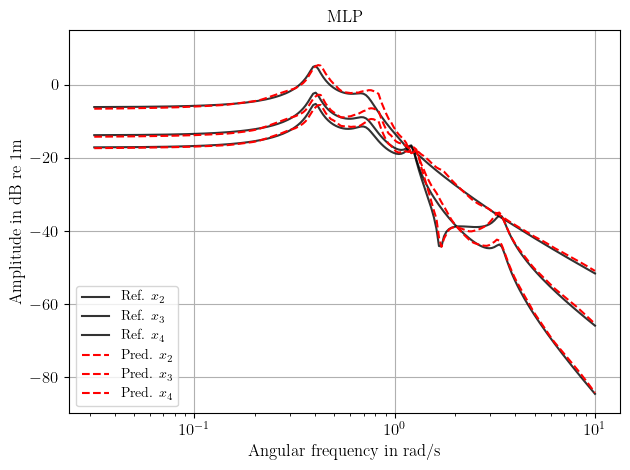

In [7]:
# MLP plots
idx_min_loss_1 = np.argmin(loss_per_sample_1)
idx_max_loss_1 = np.argmax(loss_per_sample_1)

fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_min_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP - Best prediction")
plot.legend(["Ref. $x_1$","Pred. $x_1$"], prop = {'size': legend_font_size}, loc = 'lower left')
plot.set_ylim([-35,15])
plt.tight_layout()

fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP")
plot.legend(["Ref. $x_1$","Pred. $x_1$"], prop = {'size': legend_font_size}, loc = 'lower left')
plot.set_ylim([-35,15])
plt.tight_layout()

fig, ax = plt.subplots(1, 1)
i=[1,2,3]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP")
plot.legend(["Ref. $x_2$","Ref. $x_3$","Ref. $x_4$","Pred. $x_2$","Pred. $x_3$","Pred. $x_4$"], prop = {'size': legend_font_size}, loc = 'lower left')
plot.set_ylim([-90,15])
plt.tight_layout()

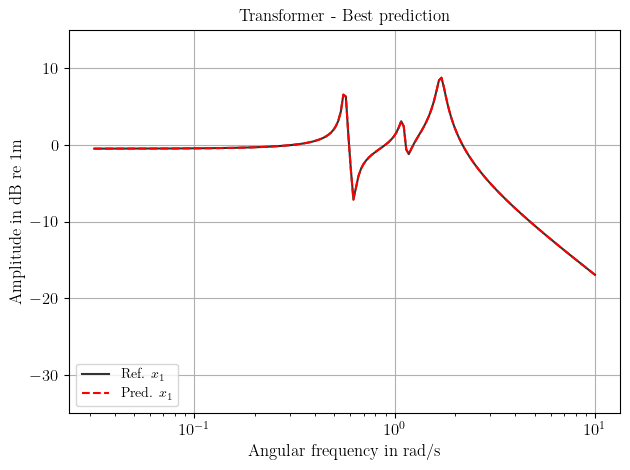

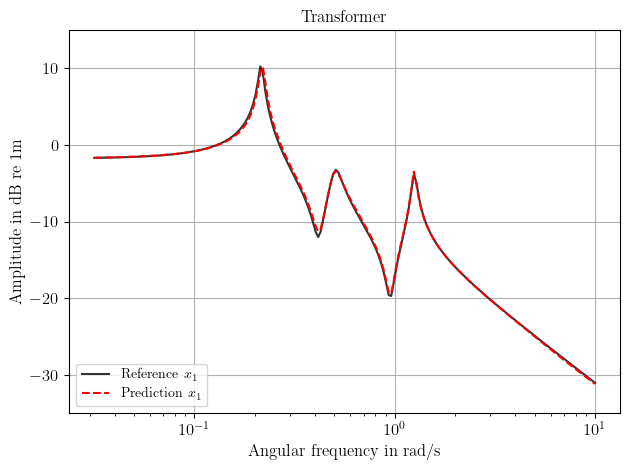

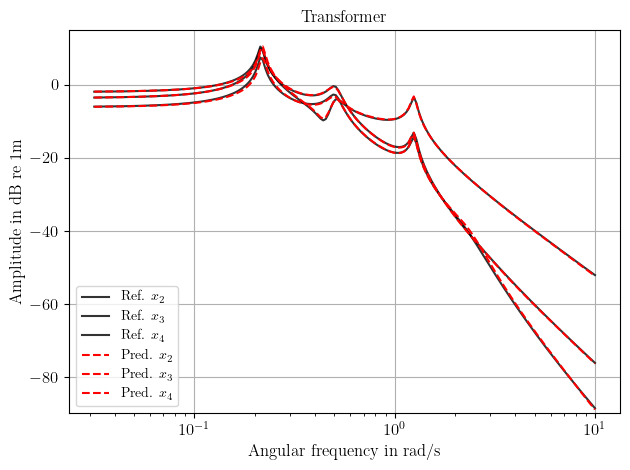

In [8]:
# Transformer plots
idx_min_loss_2 = np.argmin(loss_per_sample_2)
idx_max_loss_2 = np.argmax(loss_per_sample_2)

fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_min_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Transformer - Best prediction")
plot.legend(["Ref. $x_1$","Pred. $x_1$"], prop = {'size': legend_font_size}, loc = 'lower left')
plot.set_ylim([-35,15])
plt.tight_layout()

fig, ax = plt.subplots(1, 1)
i=[0]
num= idx_max_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Transformer")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': legend_font_size}, loc = 'lower left')
plot.set_ylim([-35,15])
plt.tight_layout()

fig, ax = plt.subplots(1, 1)
i=[1,2,3]
num= idx_max_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Transformer")
plot.legend(["Ref. $x_2$","Ref. $x_3$","Ref. $x_4$","Pred. $x_2$","Pred. $x_3$","Pred. $x_4$"], prop = {'size': legend_font_size}, loc = 'lower left')
plot.set_ylim([-90,15])
plt.tight_layout()

plt.show()